# Titanic

### Summary

1. Missing data
2. Feature engineering (feature selection?, dimensionality reduction?)
3. Model training (hyperparameter tuning - over fitting?? cross validation, model selection)
4. Accuracy metrics (roc, auc, tpr, fpr, r^2)

### Load data and imports

In [1]:
import json

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

In [2]:
raw_train = pd.read_csv('../data/titanic/train.csv')

In [3]:
raw_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data exploration

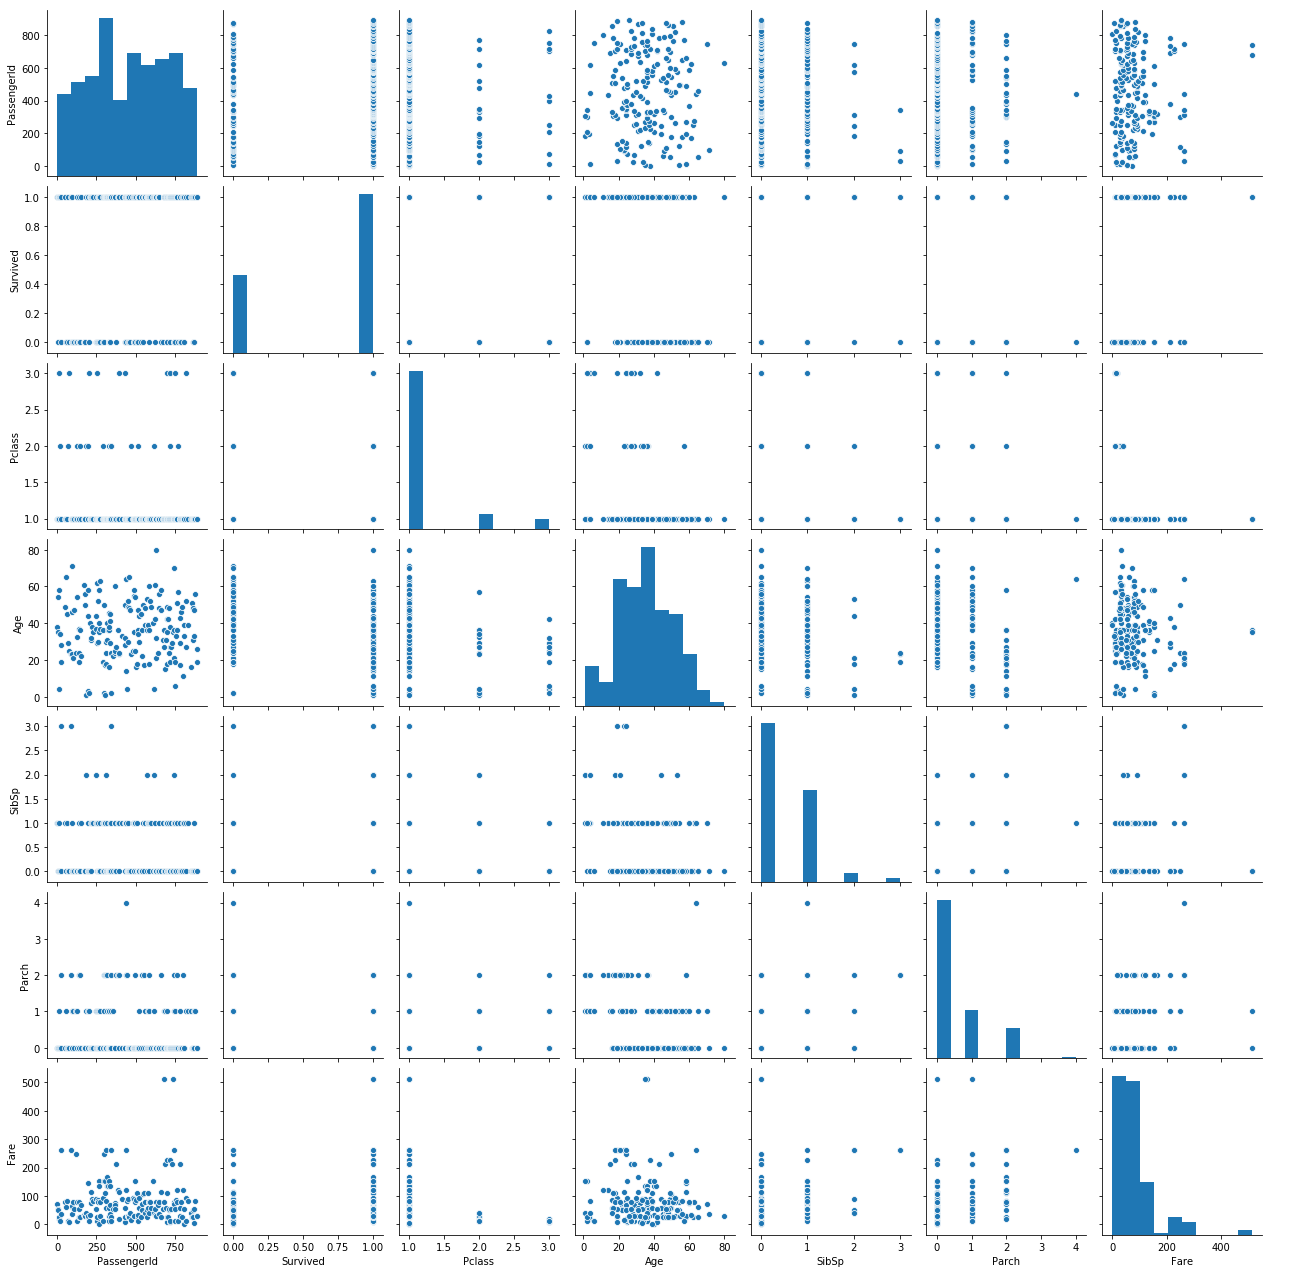

In [4]:
sns.pairplot(raw_train.dropna())

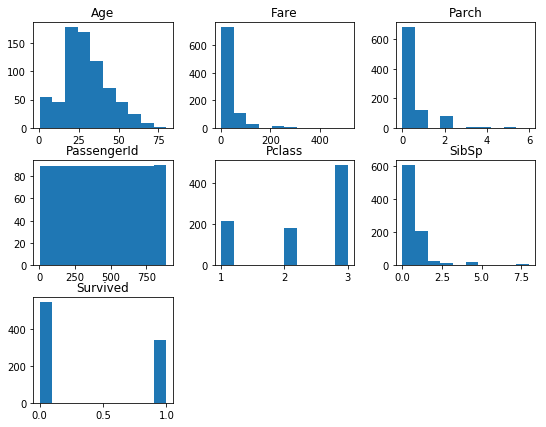

In [5]:
raw_train.hist(bins=10, figsize=(9,7), grid=False);

In [6]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
raw_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
raw_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Green, Mr. George Henry",male,347082,B96 B98,S
freq,1,577,7,4,644


In [9]:
# look at relationship with target
raw_train[["Parch", "Survived"]]\
    .groupby(['Parch'], as_index=False)\
    .mean()\
    .sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### Check for skewed data

In [10]:
# Check for skewed y
raw_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Missing values

In [11]:
pd.DataFrame(
    data=[raw_train.isna().sum()],
    index=['missing'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
missing,0,0,0,0,0,177,0,0,0,0,687,2


drop features if 
 - mostly not there
 - too many different categorical values
 
e.g. consider dropping or engineering ['Name', 'Ticket', 'Cabin'] due to high cardinality

### Feature engineering

In [12]:
def name_transform(name):
    if 'Mrs' in name:
        return 'Mrs'
    elif 'Miss' in name:
        return 'Miss'
    elif 'Mr' in name:
        return 'Mr'
    elif 'Master' in name:
        return 'Master'
    else:
        return 'Other'


class NameFeature(BaseEstimator, TransformerMixin):
    def __init__(self):
        print(f'Initialised NameFeatures')

    def fit(self,X,y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['Title'] = X['Name'].apply(name_transform)
        X = X.drop('Name', axis=1)
        return X

In [13]:
NameFeature().fit_transform(raw_train).head(2)

Initialised NameFeatures


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs


### Define features and train test split

In [14]:
all_numerical_features = [
    col for col, col_dt in raw_train.dtypes.iteritems() if col_dt not in ['O']]
all_categorical_features = [
    col for col, col_dt in raw_train.dtypes.iteritems() if col_dt in ['O']]

target_feature = ['Survived']
exclude_features = ['Ticket', 'Cabin', 'PassengerId'] + target_feature
numerical_features = [feature for feature in all_numerical_features
                      if not feature in exclude_features]
categorical_features = [feature for feature in all_categorical_features
                        if not feature in exclude_features]

# make sure to not include sneaky categorical vairables
numerical_categorical = ['Pclass', 'SibSp', 'Parch']
numerical_features = [feature for feature in numerical_features 
                      if feature not in numerical_categorical]
categorical_features += numerical_categorical
all_features = numerical_features + categorical_features

print(f'Numerical features: {", ".join(numerical_features)}')
print(f'Categorical features: {", ".join(categorical_features)}')
print(f'Excluded features: {", ".join(exclude_features)}')

X = raw_train[all_features + target_feature].copy()
y = X.pop('Survived')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

Numerical features: Age, Fare
Categorical features: Name, Sex, Embarked, Pclass, SibSp, Parch
Excluded features: Ticket, Cabin, PassengerId, Survived


### Define the pipelines

In [15]:
# define the pipelines for numerical data and categorical

numerical_pipeline = Pipeline(steps=[
    ('simimputer', SimpleImputer(strategy='mean')),
    ('standard_scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('name_feature', NameFeature()),
    ('simple_imputer', SimpleImputer(strategy='constant',fill_value='MISSING')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessing_pipeline = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])


def pipeline_feature_names(preprocessing_pipeline):
    """Helper to get transformed column names"""
    cat_one_hot_names = list(preprocessing_pipeline\
        .named_transformers_['cat']\
        .named_steps['one_hot_encoder']\
        .get_feature_names(input_features=categorical_features))
    numerical_feature_names = [feature.lower() for feature in numerical_features]
    cat_one_hot_names = [feature.lower() for feature in cat_one_hot_names]
    return numerical_feature_names + cat_one_hot_names

# Transformed data for the model
X_train_model = preprocessing_pipeline.fit_transform(X_train)
X_test_model = preprocessing_pipeline.transform(X_test)

# Convert to df - purely to save processed data in nice format for visulaising
X_train_df = pd.DataFrame(
    data=X_train_model.toarray(),
    columns=pipeline_feature_names(preprocessing_pipeline),
    index=X_train.index)
X_test_df = pd.DataFrame(
    data=X_test_model.toarray(),
    columns=pipeline_feature_names(preprocessing_pipeline))

X_train_df.head(2)

Initialised NameFeatures
Initialised NameFeatures


,age,fare,name_female,name_male,sex_c,sex_missing,sex_q,sex_s,embarked_1,embarked_2,...,sibsp_2,sibsp_3,sibsp_4,sibsp_5,sibsp_6,parch_master,parch_miss,parch_mr,parch_mrs,parch_other
331,1.232263,-0.078684,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
733,-0.500482,-0.377145,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
X_train.head(2) # before processing

,Age,Fare,Name,Sex,Embarked,Pclass,SibSp,Parch
331,45.5,28.5,"Partner, Mr. Austen",male,S,1,0,0
733,23.0,13.0,"Berriman, Mr. William John",male,S,2,0,0


### Logistic model with grid search

In [17]:
logistic_classifier = LogisticRegression(max_iter=500)

logistic_grid_params ={
    'penalty':['l1','l2'],
    'C':[0.1, 0.5, 1, 4]}

logistic_classifier_best  = GridSearchCV(
    estimator=logistic_classifier,
    param_grid=logistic_grid_params,
    scoring='accuracy', # is this the best choice?
    n_jobs=-1,
    cv=5)

logistic_classifier_best.fit(X_train_model, y_train)

n=5
first_n_preds = logistic_classifier_best.predict(X_test_model)[:n]
print(f'Logistic accuracy: {logistic_classifier_best.best_score_:0.4f}\n'
      f'Best parameters: {logistic_classifier_best.best_params_}\n'
      f'first {n} predictions {first_n_preds}')

Logistic accuracy: 0.8216
Best parameters: {'C': 1, 'penalty': 'l2'}
first 5 predictions [1 0 0 1 1]


### Radom forest model with random search

In [18]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_forest_params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap}

random_forest_classifier = RandomForestClassifier()

random_forest_params

{'n_estimators': [200, 650, 1100, 1550, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 32, 55, 77, 100, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [19]:
random_forest_best  = RandomizedSearchCV(
    estimator=random_forest_classifier,
    param_distributions=random_forest_params,
    n_iter=50,
    scoring='accuracy', # is this the best choice?
    n_jobs=-1,
    verbose=2,
    cv=3)

random_forest_best.fit(X=X_train_model, y=y_train)

print(
    f'random_forest_best accuracy: {random_forest_best.best_score_:0.4f}\n'
    f'Best parameters: {json.dumps(random_forest_best.best_params_, indent=2)}')

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


random_forest_best accuracy: 0.8287
Best parameters: {
  "n_estimators": 1100,
  "min_samples_split": 2,
  "min_samples_leaf": 2,
  "max_features": "auto",
  "max_depth": 10,
  "bootstrap": true
}


### Random forest model with grid search

In [20]:
random_forest_classifier = RandomForestClassifier()

random_forest_grid = {
    'n_estimators': [180,200,220],
    'min_samples_split': [4,5,6],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'max_depth': [70,80,90],
    'bootstrap': [False]}

random_forest_best_grid  = GridSearchCV(
    estimator=random_forest_classifier,
    param_grid=random_forest_grid,
    scoring='accuracy', # is this the best choice?
    n_jobs=-1,
    verbose=2,
    cv=3)

random_forest_best_grid.fit(X=X_train_model, y=y_train)

print(
    f'random_forest_best_grid accuracy: {random_forest_best_grid.best_score_:0.4f}\n'
    f'Best parameters: {json.dumps(random_forest_best_grid.best_params_, indent=2)}')

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    6.3s finished


random_forest_best_grid accuracy: 0.8315
Best parameters: {
  "bootstrap": false,
  "max_depth": 80,
  "max_features": "sqrt",
  "min_samples_leaf": 2,
  "min_samples_split": 6,
  "n_estimators": 180
}


### Accuracy on test data

In [21]:
log_classifier_preds = logistic_classifier_best.predict(X_test_df)
random_random_forest_preds = random_forest_best.predict(X_test_df)
grid_random_forest_preds = random_forest_best_grid.predict(X_test_df)

n_test = y_test.shape[0] 

log_classifier_acc = (log_classifier_preds == y_test).sum()  / n_test
random_random_forest_acc = (random_random_forest_preds == y_test).sum()  / n_test
grid_random_forest_acc = (grid_random_forest_preds == y_test).sum()  / n_test

print('''
logistic_classifier_best accuracy : {:.2%}
random_forest_best accuracy : {:.2%}
random_forest_best_grid accuracy : {:.2%}
'''.format(
    log_classifier_acc,
    random_random_forest_acc,
    grid_random_forest_acc))


logistic_classifier_best accuracy : 80.45%
random_forest_best accuracy : 82.12%
random_forest_best_grid accuracy : 83.80%



### Save processed data

In [23]:
X_train_df.reset_index(drop=True).to_feather('../data/titanic/processed/X_train.feather')
X_test_df.reset_index(drop=True).to_feather('../data/titanic/processed/X_test.feather')
y_train.reset_index(drop=True).to_frame().to_feather('../data/titanic/processed/y_train.feather')
y_test.reset_index(drop=True).to_frame().to_feather('../data/titanic/processed/y_test.feather')

## End